This Notebook has all the data exploration for my models and the models in this proyect
these are the problems i am trying to solve:

1.   reducing the false positive rate by making this into a classification problem
2.   creating a linear model that can predict the aproximate close price of a trade.




In [57]:
%config IPCompleter.greedy=True

In [58]:
#first lets import the trinity of Python 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This Data is from myfxbook.com you can find it in [this link](https://www.myfxbook.com/strategies/sterlingxp-expert-advisor-fixed-lot/226294) this is a 5 year backtest from a live trading account in IG markets

In [59]:
#NOW lets load our dataset!
df = pd.read_csv('myfxbookdata.csv')
df.head(5)


,Open Date,Close Date,Symbol,Action,Lots,SL,TP,Open Price,Close Price,Pips,Profit,Duration (DD:HH:MM:SS),Change %
0,04/02/2020 16:30,04/02/2020 23:59,GBPUSD,Sell,1.5,1.24420,1.23320,1.23720,1.23926,-20.6,-296.41,00:07:29:00,-0.28
1,04/02/2020 12:00,04/02/2020 13:22,GBPUSD,Buy,1.5,1.23533,1.24633,1.24233,1.24633,40.0,544.67,00:01:22:00,0.52
2,03/25/2020 18:00,03/25/2020 18:22,GBPUSD,Buy,1.5,1.16878,1.17978,1.17578,1.17978,40.0,544.67,00:00:22:00,0.53
3,03/25/2020 16:00,03/25/2020 16:18,GBPUSD,Sell,1.5,1.18371,1.17271,1.17671,1.17271,40.0,544.67,00:00:18:00,0.53
4,03/25/2020 11:00,03/25/2020 11:54,GBPUSD,Buy,1.5,1.18523,1.19623,1.19223,1.19623,40.0,544.67,00:00:54:00,0.53


In [60]:
#this data has no missing vals
df.isnull().sum()

Open Date                 0
Close Date                0
Symbol                    0
Action                    0
Lots                      0
SL                        0
TP                        0
Open Price                0
Close Price               0
Pips                      0
Profit                    0
Duration (DD:HH:MM:SS)    0
Change %                  0
dtype: int64

In [61]:
# data types are mostly float values
df.dtypes

Open Date                  object
Close Date                 object
Symbol                     object
Action                     object
Lots                      float64
SL                        float64
TP                        float64
Open Price                float64
Close Price               float64
Pips                      float64
Profit                    float64
Duration (DD:HH:MM:SS)     object
Change %                  float64
dtype: object

In [62]:
# now lets define a fucntion to make wrangle our dataset
def wrangle(x):
    x = x.copy()
    #removing spaces and upper cases
    x.columns = x.columns.str.lower()
    x.columns = x.columns.str.replace(' ','_')
    
    #engeneering a few features
    x['win/loss'] = x['profit'] > 0 #this feature will determine if there is a winning or losing trade
    features_ = x.loc[:,'sl':'open_price'] #this variable subsets my main columns openprice, stoploss and take profit
    x['mean'] = features_.mean(axis=1)
    x['med'] = features_.median(axis=1)
    x['std'] = features_.std(axis=1)
    multiplier = 0.0001

    x['risk_reward'] = round((x['sl']-x['tp'])/multiplier)
    
    #dropping some of the features that cause leakage
    x = x.drop(labels=['profit','pips','change_%',"duration_(dd:hh:mm:ss)"],axis=1)
    
    #setting columns as datetime
    x['open_date'] = pd.to_datetime(x['open_date'])
    x['close_date'] = pd.to_datetime(x['close_date'])
    return x
    
    
    
    

In [63]:
#now we apply the function to our dataset!
df = wrangle(df)

# For our data exploration we will use a new library called Dtale
Dtale makes data exploration easier and in my opinion is more powerfull than pandas profiling

In [64]:
#here is dtale, you can install it simply by using !pip install 
import dtale as dtale

In [65]:
dtale.show(df,ignore_duplicate=True) #to start exploring the data just click on the play button on the top left corner of the table

In [66]:
#now lets subset our data into a time based split
#the train set will be data before our cutoff, the test data will be 
#data after our cutoff date
cutoff = pd.to_datetime('2018/11/1')#<---cutoff date
train = df[df['open_date']<=cutoff]
test = df[df['open_date']>cutoff]

In [67]:
train.shape , test.shape

((981, 14), (315, 14))

## Lets take a look at our baseline to see what are we trying to beat in our model:


In [68]:
#baseline with value counts function
dist = df['win/loss'].value_counts(normalize=True)
dist

True     0.695988
False    0.304012
Name: win/loss, dtype: float64

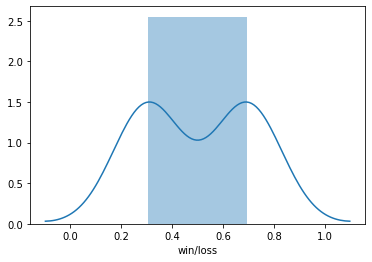

In [69]:
#lets visualize it
import seaborn as sns
sns.distplot(dist);

In [70]:
# now lets subset our data into x and y
# here is our target and features for our classification problem
target = 'win/loss'
features = ['action','sl','tp','open_price','mean','close_price','risk_reward']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_test_rf = X_test.copy()
y_test_rf = y_test.copy()

In [71]:
#lets fit a regular linear regression and use that as our baseline model, then we will try to 
#improve it if possible
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


In [72]:
#pipeline with 2 steps
pipeline = make_pipeline(
    ce.BinaryEncoder(),
    LogisticRegression()
)

In [73]:
#now lets fit it!
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('binaryencoder',
                 BinaryEncoder(cols=None, drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               mapping=None, return_df=True, verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [74]:
#now lets use cross val score to measure how good our model is
from sklearn.model_selection import cross_val_score

In [75]:
from sklearn.metrics import roc_auc_score
lg_cvscore = cross_val_score(pipeline,X_train,y_train,scoring='roc_auc')
lg_cvscore

array([0.50815085, 0.36348039, 0.55895088, 0.53334158, 0.40121242])

In [76]:
#what is the average validation accuracy?
np.mean(lg_cvscore)

0.47302722610756537

so our baseline model pretty much predicted the normal distribution of our model when it comes to accuracy, but how does it perform with RoC AuC scores?

In [77]:
from sklearn.metrics import roc_auc_score

In [78]:
from sklearn.metrics import roc_auc_score

y_pred_probab = pipeline.predict_proba(X_test)[:, -1]
roc_auc_score(y_test, y_pred_probab)

0.4607490778397806

OUCH! a 46% ROC AUC score! that is not good...

In [79]:
#Now lets try one of my favorite models: Randomforestclassifier
pipeline_rf = make_pipeline(
    ce.BinaryEncoder(),
    RandomForestClassifier()
)

In [80]:
# lets fit it
pipeline_rf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('binaryencoder',
                 BinaryEncoder(cols=None, drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               mapping=None, return_df=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                          

In [81]:
# now lets see the validation accuracy to see if it improves
rf_cvscore = cross_val_score(pipeline_rf,X_train,y_train,scoring='roc_auc',cv=21)
rf_cvscore

array([0.88958333, 0.853125  , 0.84791667, 0.62012987, 0.90692641,
       0.97186147, 0.94480519, 0.7965368 , 0.69588745, 0.71536797,
       0.98917749, 0.88852814, 0.49242424, 0.75865801, 0.76839827,
       0.74776786, 0.7578125 , 0.8359375 , 0.86607143, 0.76227679,
       0.765625  ])

In [82]:
np.mean(rf_cvscore)

0.8035627319109463

In [83]:
# now lets see what is the ROC AUC score on this model...
y_pred_probab = pipeline_rf.predict_proba(X_test)[:, -1]
roc_auc_score(y_test, y_pred_probab)

0.8817743308427125

Wow that is way better!, lets plot this ROC AUC line!

In [84]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probab)

pd.DataFrame({
  'False Positive Rate': fpr,
  'True Positive Rate': tpr,
  'Threshold': thresholds          
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.00
1,0.000000,0.068807,1.00
2,0.000000,0.142202,0.99
3,0.000000,0.238532,0.98
4,0.000000,0.247706,0.97
...,...,...,...
68,0.917526,1.000000,0.09
69,0.958763,1.000000,0.07
70,0.969072,1.000000,0.06
71,0.989691,1.000000,0.05


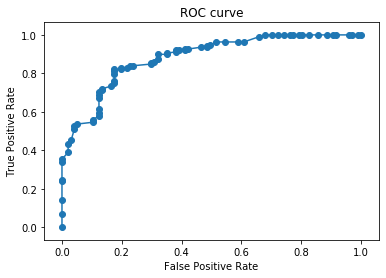

In [85]:
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

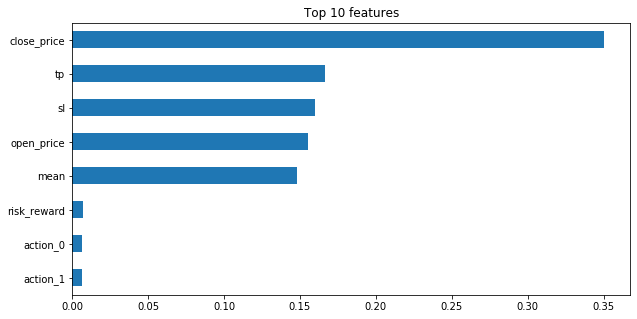

In [86]:
#now lets try to plot permutation importances:
#feature importances

%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
encoder = pipeline_rf.named_steps['binaryencoder']
encoded = encoder.transform(X_train)

rf = pipeline_rf.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

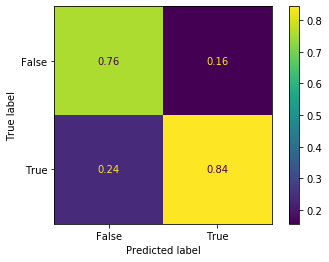

In [87]:
from sklearn.metrics import plot_confusion_matrix
enc_test = encoder.transform(X_test)
dist = plot_confusion_matrix(rf,enc_test,y_test,normalize='pred')

In [88]:
!pip install pdpbox

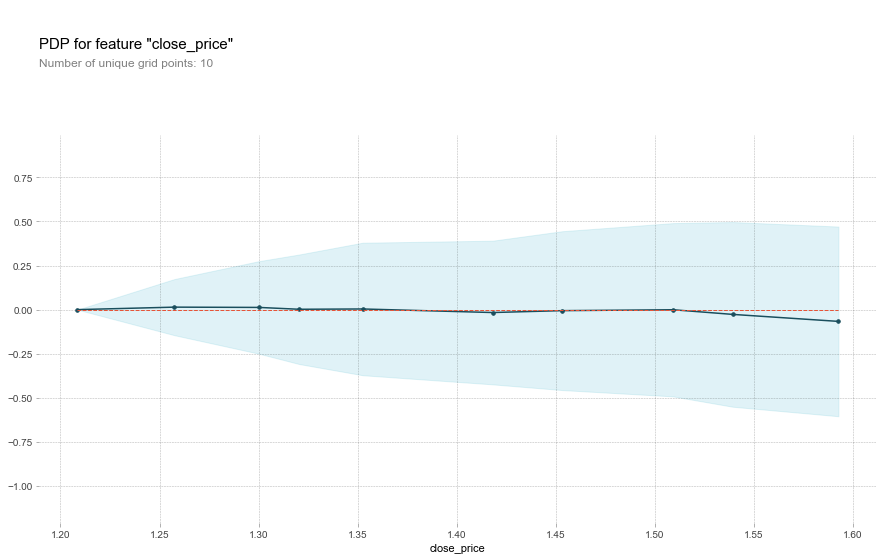

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'close_price'
X_encoded = encoder.transform(X_test)
#X_imputed = imputer.transform(X_encoded)
pdp_dist = pdp.pdp_isolate(model=rf, dataset=encoded, model_features=X_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [90]:
#now the real permutation importances
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    rf,
    scoring='roc_auc',
    n_iter=5,
    random_state=42
)

permuter.fit(encoded, y_train)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [91]:
feature_names = encoded.columns.tolist()
#pd.Series(permuter.feature_importances_, feature_names).sort_values()
eli5.show_weights(permuter,top=20,feature_names=feature_names)

Weight,Feature
0.2836 ± 0.0360,close_price
0.0215 ± 0.0023,open_price
0.0212 ± 0.0035,tp
0.0146 ± 0.0018,sl
0.0092 ± 0.0034,mean
0.0000 ± 0.0000,action_1
0 ± 0.0000,risk_reward
0 ± 0.0000,action_0


Now. this model is highly dependent on the close price feature, which at the time of the trade we do not now with certainty, how our trade is going to close
, now we have to make another model that can predict aproximately what the close price can be for any given trade, and use that into our first model and try to make an accurate prediction




In [92]:
# first lets redefine our targets and features
# in this clase Close_price will be our target.
target = 'close_price'
features = ['action','sl','tp','open_price','risk_reward','mean']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [93]:
from sklearn.linear_model import Ridge

In [94]:
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score


In [95]:
pipeline = make_pipeline(
    ce.BinaryEncoder(),
    Ridge()
)

In [96]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('binaryencoder',
                 BinaryEncoder(cols=None, drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               mapping=None, return_df=True, verbose=0)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [97]:
ridge_cvscore = cross_val_score(pipeline,X_train,y_train,scoring='r2')
ridge_cvscore

array([0.98471676, 0.9713349 , 0.99479027, 0.98861868, 0.91524183])

In [98]:
from sklearn.metrics import r2_score
y_pred = pipeline.predict(X_test)
r2_score(y_test,y_pred)

0.9737343500179033

In [99]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_pred,y_test)

0.004875578794760977

In [100]:
ridge = pipeline.named_steps['ridge']

In [101]:
ridge.get_params

<bound method BaseEstimator.get_params of Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)>

In [102]:
# now lets try to make some Hyperparameter tuning on this model to try to bring the 
# MAE down
import random
from sklearn.model_selection import RandomizedSearchCV
param_dist={'ridge__alpha':(0.1,1.0,10.0,0.0001),
            'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
           #'ridge__random_state':range(0,42),
            'ridge__max_iter':range(100,1000),
            
           }

In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=3,  
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

In [104]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:    2.6s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:    2.6s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    2.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    2.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.8s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('binaryencoder',
                                              BinaryEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            mapping=None,
                                                            return_df=True,
                                                            verbose=0)),
                                             ('ridge',
                                              Ridge(alpha=1.0, copy_X=True,
                                                    fit_intercept=True,
                                                    max_iter=None,
                              

In [105]:
#pipeline.get_params().keys()
pipeline = search.best_estimator_

In [106]:
y_pred = pipeline.predict(X_test)
mean_absolute_error(y_pred,y_test)

0.004665942309728856

In [107]:
X_test_rf['close_price'] = y_pred
X_test_rf

,action,sl,tp,open_price,mean,close_price,risk_reward
0,Sell,1.24420,1.23320,1.23720,1.23820,1.237028,110.0
1,Buy,1.23533,1.24633,1.24233,1.24133,1.243468,-110.0
2,Buy,1.16878,1.17978,1.17578,1.17478,1.177109,-110.0
3,Sell,1.18371,1.17271,1.17671,1.17771,1.176712,110.0
4,Buy,1.18523,1.19623,1.19223,1.19123,1.193512,-110.0
...,...,...,...,...,...,...,...
310,Sell,1.31729,1.30629,1.31029,1.31129,1.309908,110.0
311,Sell,1.30976,1.29876,1.30276,1.30376,1.302399,110.0
312,Buy,1.29349,1.30449,1.30049,1.29949,1.301460,-110.0
313,Sell,1.30683,1.29583,1.29983,1.30083,1.299478,110.0


In [109]:
from sklearn.metrics import accuracy_score

In [110]:
rf_copy_pred = pipeline_rf.predict(X_test_rf)

In [111]:
accuracy_score(rf_copy_pred,y_test_rf)

0.6222222222222222

In [115]:
# ROC AUC score for the new set with predicted close prices
predict_proba_rf = pipeline_rf.predict_proba(X_test_rf)[:, -1]
roc_auc_score(y_test_rf,predict_proba_rf)

0.4772297361203064

In [127]:
# Versions Used in this notebook
print('pandas version',pd.__version__)
print('Numpy version',np.__version__)
import matplotlib
print('matplotlib version',matplotlib.__version__)
import sklearn
print('Sklearn version',sklearn.__version__)

pandas version 1.0.1
Numpy version 1.18.1
matplotlib version 3.1.3
Sklearn version 0.22.1
